In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import json

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
%cd "/content/drive/My Drive/ada_project"
!ls

/content/drive/My Drive/ada_project
ada_project.ipynb		      quotes-2020-china_trade.json.bz2
baseline_w2v_china_trade_2018.json    sentiment_china_trade_2018.json
china_trade_2018.json		      sentiment_dictionary.csv
china_trade_vader_sentiment.json      stock_data
china_trade_zero_shot_sentiment.json  US_China_Baseline.ipynb
quotes-2018-china.json.bz2	      vader_sentiment.ipynb
quotes-2018-china_trade.json.bz2      w2v_unsupervised_sentiment.ipynb
quotes-2019-china.json.bz2	      word2vec.model
quotes-2019-china_trade.json.bz2      zero_shot_sentiment.ipynb
quotes-2020-china.json.bz2


In [5]:
quotes = pd.read_json('china_trade_zero_shot_sentiment.json', orient='records', lines=True)
stock = pd.read_csv('stock_data/BG_data.csv')

In [6]:
quotes.head()

,quoteID,quotation,speaker,date,numOccurrences,bart_sentiment
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,2018-04-13,1,positive
1,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,2018-03-23,2,negative
2,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,2018-08-04,17,negative
3,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,2018-05-14,2,negative
4,2018-11-29-030995,"he would be able to strike a chord with Xi, wh...",A. Khan,2018-11-29,1,positive


In [7]:
stock.head()

,Date,Open,High,Low,Close,Volume,Log_returns,Log_return_onehot
0,2018-01-02,58.842545,59.542735,58.159851,59.507725,944500,NaN,NaN
1,2018-01-03,59.849074,61.450770,59.568997,60.785583,2124600,0.021247,1.0
2,2018-01-04,61.074403,62.325999,61.048146,61.678322,2026900,0.014580,1.0
3,2018-01-05,61.704588,62.133455,60.873111,61.214455,795500,-0.007549,-1.0
4,2018-01-08,61.048154,61.065656,59.726536,60.330456,1041200,-0.014546,-1.0


In [8]:
quotes.bart_sentiment = quotes.bart_sentiment.apply(lambda x: 1.0 if x == 'positive' else - 1.0)
quotes.head()

,quoteID,quotation,speaker,date,numOccurrences,bart_sentiment
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,2018-04-13,1,1.0
1,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,2018-03-23,2,-1.0
2,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,2018-08-04,17,-1.0
3,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,2018-05-14,2,-1.0
4,2018-11-29-030995,"he would be able to strike a chord with Xi, wh...",A. Khan,2018-11-29,1,1.0


Basic dataset analyses

In [9]:
if len(np.unique(quotes.quotation)) == len(quotes):
    print('There are {} unique quotations'.format(len(quotes)))

There are 36591 unique quotations


In [10]:
print('There are {} unique predicted speakers'.format(len(np.unique(quotes.speaker))))

There are 7244 unique predicted speakers


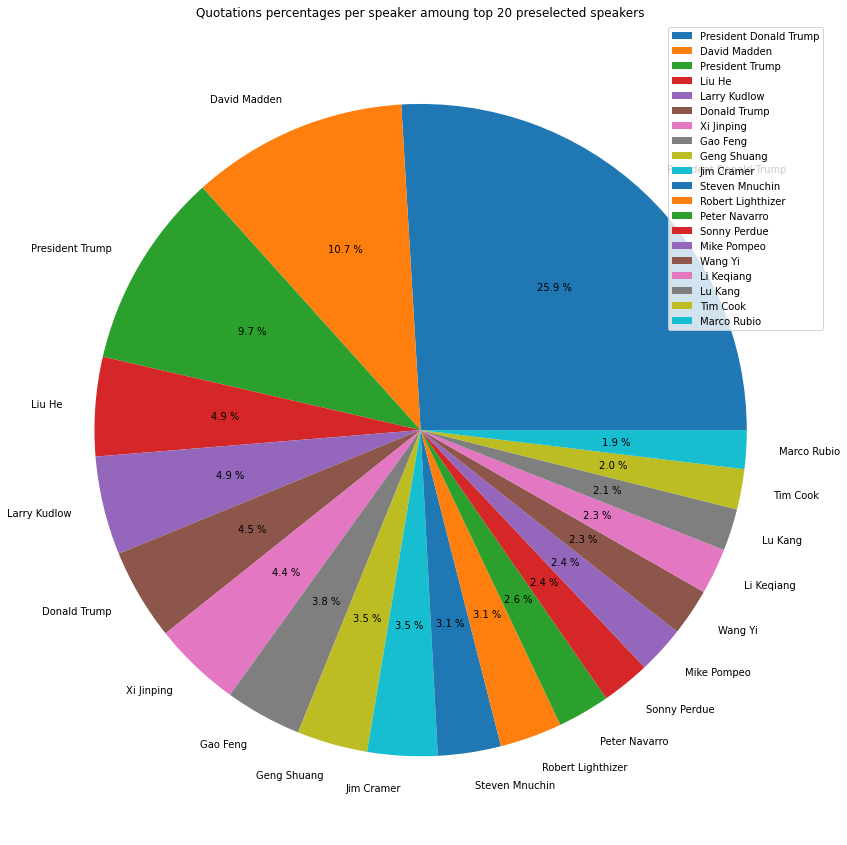

In [11]:
top_20_speakers = quotes[quotes.speaker != 'None'].speaker.value_counts().nlargest(n=20)
top_20_speakers = top_20_speakers / len(top_20_speakers)
top_20_speakers.plot.pie(autopct='%.1f %%', ylabel='', legend=True, figsize=(15, 15))
plt.title('Quotations percentages per speaker amoung top 20 preselected speakers')
plt.show()

In [12]:
from wordcloud import WordCloud

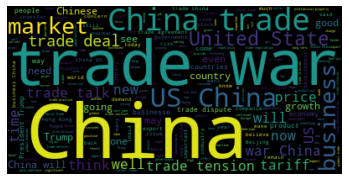

In [13]:
wordcloud = WordCloud().generate(' '.join(quotes.quotation))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
sent_per_day = quotes[['date', 'bart_sentiment']].groupby(['date']).sum()
sent_per_day

,bart_sentiment
date,
2018-01-01,-2.0
2018-01-02,26.0
2018-01-03,-14.0
2018-01-04,-1.0
2018-01-05,5.0
...,...
2020-11-04,-4.0
2020-12-01,7.0
2020-12-02,-22.0


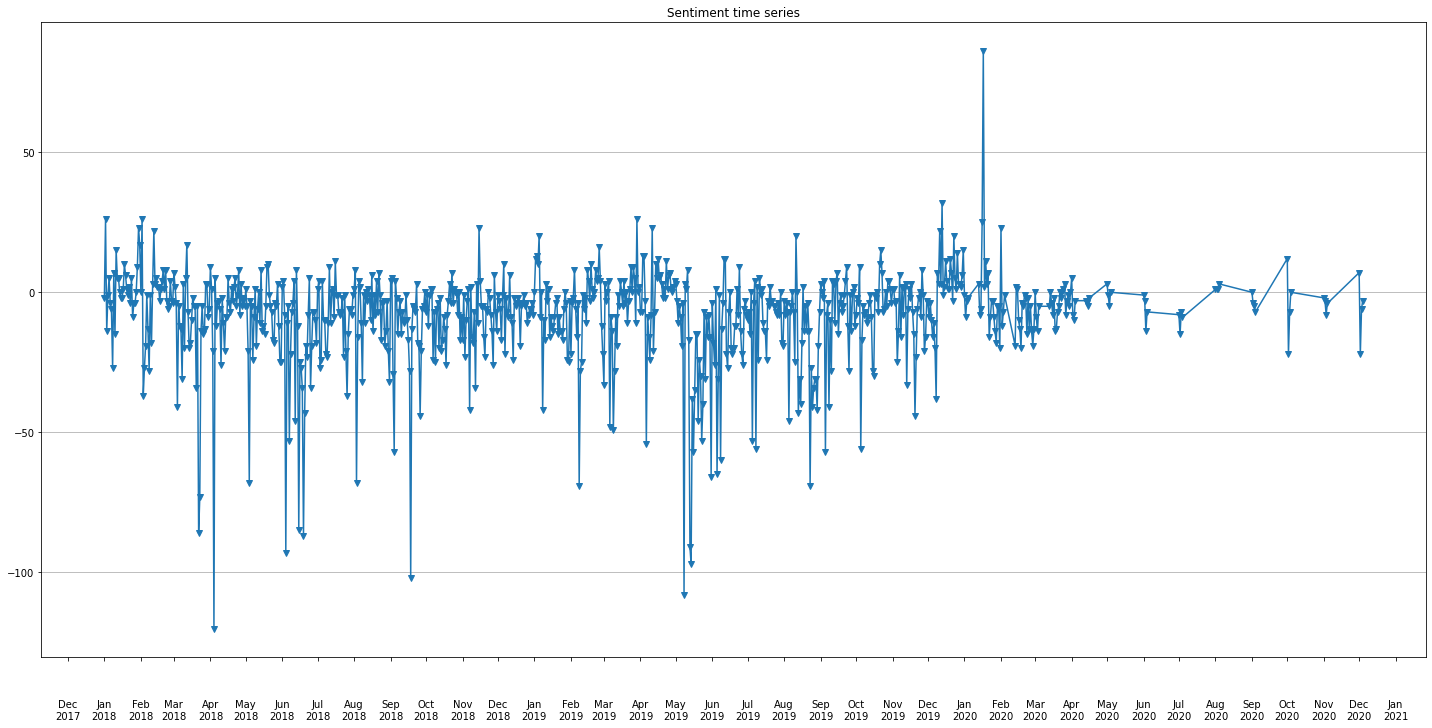

In [15]:
import matplotlib.dates as dates

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot_date(sent_per_day.index.to_pydatetime(), sent_per_day.bart_sentiment, 'v-')
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.title('Sentiment time series')
plt.show()

In [16]:
quotes['weighted_sent'] = quotes.bart_sentiment * quotes.numOccurrences
quotes.head()

,quoteID,quotation,speaker,date,numOccurrences,bart_sentiment,weighted_sent
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,2018-04-13,1,1.0,1.0
1,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,2018-03-23,2,-1.0,-2.0
2,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,2018-08-04,17,-1.0,-17.0
3,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,2018-05-14,2,-1.0,-2.0
4,2018-11-29-030995,"he would be able to strike a chord with Xi, wh...",A. Khan,2018-11-29,1,1.0,1.0


In [17]:
weighted_sent_per_day = quotes[['date', 'weighted_sent']].groupby(['date']).sum()
weighted_sent_per_day

,weighted_sent
date,
2018-01-01,-75.0
2018-01-02,366.0
2018-01-03,-12.0
2018-01-04,-318.0
2018-01-05,-44.0
...,...
2020-11-04,-56.0
2020-12-01,20.0
2020-12-02,-74.0


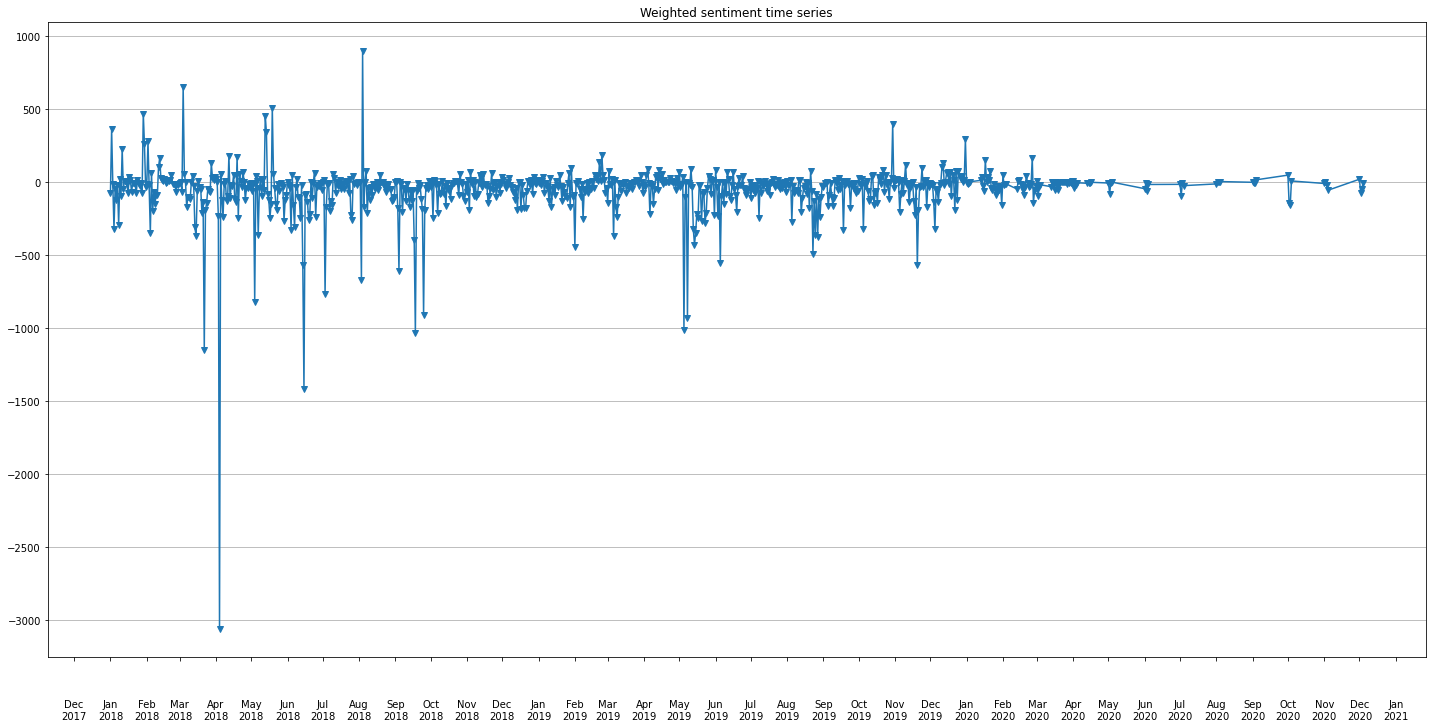

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot_date(weighted_sent_per_day.index.to_pydatetime(), weighted_sent_per_day.weighted_sent, 'v-')
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.title('Weighted sentiment time series')
plt.show()

In [19]:
stock.head()

,Date,Open,High,Low,Close,Volume,Log_returns,Log_return_onehot
0,2018-01-02,58.842545,59.542735,58.159851,59.507725,944500,NaN,NaN
1,2018-01-03,59.849074,61.450770,59.568997,60.785583,2124600,0.021247,1.0
2,2018-01-04,61.074403,62.325999,61.048146,61.678322,2026900,0.014580,1.0
3,2018-01-05,61.704588,62.133455,60.873111,61.214455,795500,-0.007549,-1.0
4,2018-01-08,61.048154,61.065656,59.726536,60.330456,1041200,-0.014546,-1.0


In [20]:
stock[stock.Log_return_onehot.isnull()]

,Date,Open,High,Low,Close,Volume,Log_returns,Log_return_onehot
0,2018-01-02,58.842545,59.542735,58.159851,59.507725,944500,NaN,NaN


In [21]:
stock.fillna(method='bfill', inplace=True)

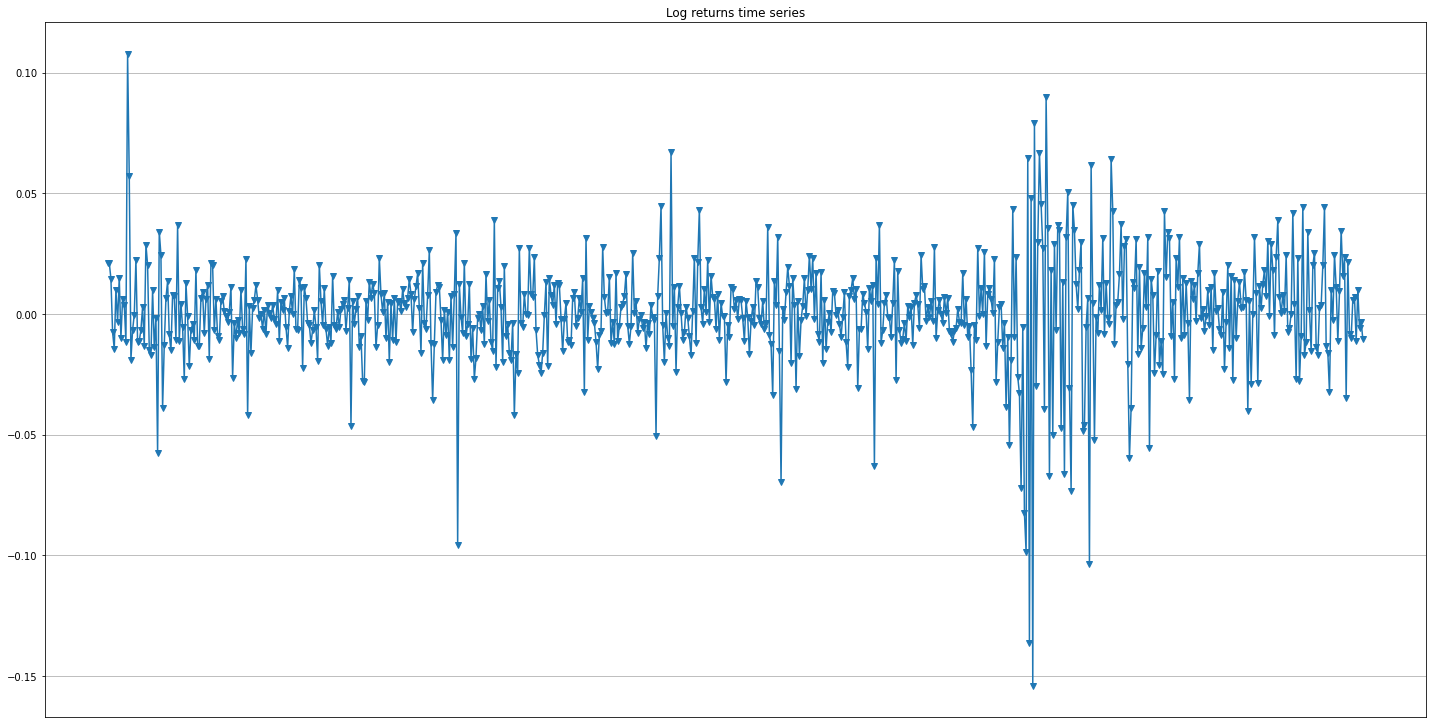

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot_date(stock.Date, stock.Log_returns, 'v-')
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.title('Log returns time series')
plt.show()

In [23]:
data = sent_per_day.join(stock.set_index('Date'))[['bart_sentiment', 'Log_return_onehot']]
data.fillna(method='bfill', inplace=True)
data = data.join(weighted_sent_per_day)

In [24]:
data.head()

,bart_sentiment,Log_return_onehot,weighted_sent
date,,,
2018-01-01,-2.0,1.0,-75.0
2018-01-02,26.0,1.0,366.0
2018-01-03,-14.0,1.0,-12.0
2018-01-04,-1.0,1.0,-318.0
2018-01-05,5.0,-1.0,-44.0


In [25]:
data.rename({'bart_sentiment': 'sum_sent', 'Log_return_onehot': 'stock_var'}, axis=1, inplace=True)
data.head()

,sum_sent,stock_var,weighted_sent
date,,,
2018-01-01,-2.0,1.0,-75.0
2018-01-02,26.0,1.0,366.0
2018-01-03,-14.0,1.0,-12.0
2018-01-04,-1.0,1.0,-318.0
2018-01-05,5.0,-1.0,-44.0


In [26]:
data['sent'] = data.sum_sent.apply(lambda x: 1.0 if x >= 0.0 else -1.0)
data.head()

,sum_sent,stock_var,weighted_sent,sent
date,,,,
2018-01-01,-2.0,1.0,-75.0,-1.0
2018-01-02,26.0,1.0,366.0,1.0
2018-01-03,-14.0,1.0,-12.0,-1.0
2018-01-04,-1.0,1.0,-318.0,-1.0
2018-01-05,5.0,-1.0,-44.0,1.0


In [27]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [28]:
mod = smf.ols(formula='stock_var ~ sum_sent', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              stock_var   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1219
Date:                Thu, 16 Dec 2021   Prob (F-statistic):              0.727
Time:                        09:18:06   Log-Likelihood:                -1187.5
No. Observations:                 837   AIC:                             2379.
Df Residuals:                     835   BIC:                             2389.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0167      0.039     -0.433      0.6

In [29]:
mod = smf.ols(formula='stock_var ~ sent', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              stock_var   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01605
Date:                Thu, 16 Dec 2021   Prob (F-statistic):              0.899
Time:                        09:18:06   Log-Likelihood:                -1187.6
No. Observations:                 837   AIC:                             2379.
Df Residuals:                     835   BIC:                             2389.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0088      0.038     -0.233      0.8

In [30]:
len(data[data.sent == data.stock_var]) / len(data)

0.5041816009557945

In [31]:
data['diff'] = (data.sent == data.stock_var).astype(int)
data.head()

,sum_sent,stock_var,weighted_sent,sent,diff
date,,,,,
2018-01-01,-2.0,1.0,-75.0,-1.0,0
2018-01-02,26.0,1.0,366.0,1.0,1
2018-01-03,-14.0,1.0,-12.0,-1.0,0
2018-01-04,-1.0,1.0,-318.0,-1.0,0
2018-01-05,5.0,-1.0,-44.0,1.0,0


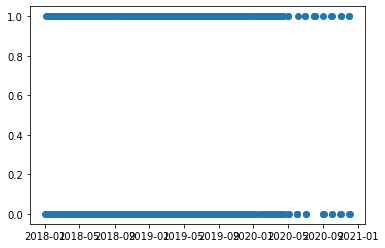

In [32]:
plt.scatter(data.index, data['diff'])
plt.show()

In [45]:
import datetime as dt
start = data.index.searchsorted(dt.datetime(2018, 1, 1))
end = data.index.searchsorted(dt.datetime(2018, 2, 1))
zoom = data.iloc[start:end]

In [46]:
zoom.head(10)

,sum_sent,stock_var,weighted_sent,sent,diff
date,,,,,
2018-01-01,-2.0,1.0,-75.0,-1.0,0
2018-01-02,26.0,1.0,366.0,1.0,1
2018-01-03,-14.0,1.0,-12.0,-1.0,0
2018-01-04,-1.0,1.0,-318.0,-1.0,0
2018-01-05,5.0,-1.0,-44.0,1.0,0
2018-01-06,-4.0,-1.0,-122.0,-1.0,1
2018-01-07,-6.0,-1.0,-19.0,-1.0,1
2018-01-08,-27.0,-1.0,-291.0,-1.0,1
2018-01-09,7.0,1.0,21.0,1.0,1


In [49]:
zoom['avg_sent_3_days'] = zoom.sent.rolling(window=3,min_periods=0).mean()
zoom.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sum_sent,stock_var,weighted_sent,sent,diff,avg_sent_3_days
date,,,,,,
2018-01-01,-2.0,1.0,-75.0,-1.0,0,-1.000000
2018-01-02,26.0,1.0,366.0,1.0,1,0.000000
2018-01-03,-14.0,1.0,-12.0,-1.0,0,-0.333333
2018-01-04,-1.0,1.0,-318.0,-1.0,0,-0.333333
2018-01-05,5.0,-1.0,-44.0,1.0,0,-0.333333


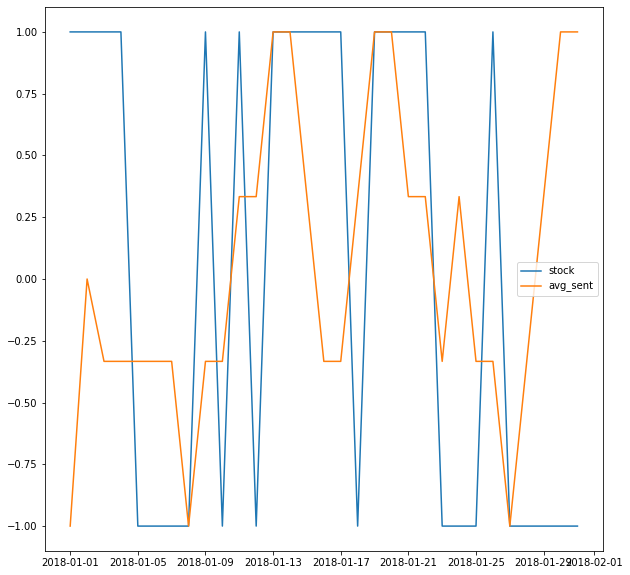

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
# plt.plot(zoom.index, zoom.sent, label='sentiment')
plt.plot(zoom.index, zoom.stock_var, label='stock')
plt.plot(zoom.index, zoom.avg_sent_3_days, label='avg_sent')
plt.legend()
plt.show()

In [55]:
zoom['avg_sent_3_days_norm'] = zoom.avg_sent_3_days.apply(lambda x: x/np.abs(x) if x != 0.0 else 1.0)
zoom.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sum_sent,stock_var,weighted_sent,sent,diff,avg_sent_3_days,avg_sent_3_days_norm
date,,,,,,,
2018-01-01,-2.0,1.0,-75.0,-1.0,0,-1.000000,-1.0
2018-01-02,26.0,1.0,366.0,1.0,1,0.000000,1.0
2018-01-03,-14.0,1.0,-12.0,-1.0,0,-0.333333,-1.0
2018-01-04,-1.0,1.0,-318.0,-1.0,0,-0.333333,-1.0
2018-01-05,5.0,-1.0,-44.0,1.0,0,-0.333333,-1.0


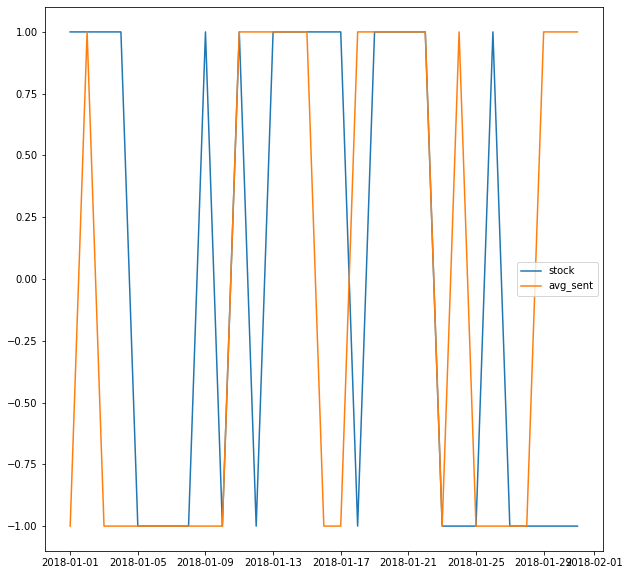

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
# plt.plot(zoom.index, zoom.sent, label='sentiment')
plt.plot(zoom.index, zoom.stock_var, label='stock')
plt.plot(zoom.index, zoom.avg_sent_3_days_norm, label='avg_sent')
plt.legend()
plt.show()

In [57]:
mod = smf.ols(formula='stock_var ~ avg_sent_3_days_norm', data=zoom)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              stock_var   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7866
Date:                Thu, 16 Dec 2021   Prob (F-statistic):              0.382
Time:                        09:54:30   Log-Likelihood:                -43.556
No. Observations:                  31   AIC:                             91.11
Df Residuals:                      29   BIC:                             93.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0375 

In [58]:
data['avg_sent_3_days'] = data.sent.rolling(window=3,min_periods=0).mean()
data.head()

,sum_sent,stock_var,weighted_sent,sent,diff,avg_sent_3_days
date,,,,,,
2018-01-01,-2.0,1.0,-75.0,-1.0,0,-1.000000
2018-01-02,26.0,1.0,366.0,1.0,1,0.000000
2018-01-03,-14.0,1.0,-12.0,-1.0,0,-0.333333
2018-01-04,-1.0,1.0,-318.0,-1.0,0,-0.333333
2018-01-05,5.0,-1.0,-44.0,1.0,0,-0.333333


In [59]:
data['avg_sent_3_days_norm'] = data.avg_sent_3_days.apply(lambda x: x/np.abs(x) if x != 0.0 else 1.0)
data.head()

,sum_sent,stock_var,weighted_sent,sent,diff,avg_sent_3_days,avg_sent_3_days_norm
date,,,,,,,
2018-01-01,-2.0,1.0,-75.0,-1.0,0,-1.000000,-1.0
2018-01-02,26.0,1.0,366.0,1.0,1,0.000000,1.0
2018-01-03,-14.0,1.0,-12.0,-1.0,0,-0.333333,-1.0
2018-01-04,-1.0,1.0,-318.0,-1.0,0,-0.333333,-1.0
2018-01-05,5.0,-1.0,-44.0,1.0,0,-0.333333,-1.0
